## Strava Activity Analysis

### 1. Import activity data with Strava's API

In [1]:
import json
import requests
import urllib3
import pandas as pd
from pandas.io.json import json_normalize
import calendar 

import matplotlib.pyplot as plt
import seaborn as sns


import strava_config as cfg

pd.set_option('display.max_columns', None)

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

auth_url = "https://www.strava.com/oauth/token"
activities_url = "https://www.strava.com/api/v3/athlete/activities"

#get config data from "strava_config" file 
payload = {
    'client_id': cfg.secrets['client_id'],
    'client_secret': cfg.secrets['client_secret'],
    'refresh_token': cfg.secrets['refresh_token'],
    'grant_type': "refresh_token",
    'f': 'json'
}


#using strava config data, get a new access token  

print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
print("Access Token = {}\n".format(access_token))

#using the access token, request 200 activities (max allowed), add to "activities" list
#increment page by 1, get next 200 break if 

header = {'Authorization': 'Bearer ' + access_token}

activities = []
page = 1
per_page = 200

while True:
    params = {'page': page, 'per_page': per_page}
    json_dataset = requests.get(activities_url, headers=header, params=params).json()
    activities += json_dataset
    if len(json_dataset) < per_page:
        break
    page += 1

print(f"Retrieved {len(activities)} activities.")

#decode polyline into list of coordinates for each route.
# polylines = [activity["map"]["summary_polyline"] for activity in activities]
# coords = [polyline.decode(polyline_str) for polyline_str in polylines]


# Load the nested JSON list into a Pandas DataFrame
df = json_normalize(activities)

# df['coords'] = coords
df.head()
#select columns of interest
#df = df[["name","id","gear_id","sport_type","start_date","distance","moving_time","elapsed_time","average_heartrate","max_heartrate","average_speed","max_speed","average_temp",
#"average_watts","comment_count","start_latlng","end_latlng","achievement_count","elev_high","elev_low","total_elevation_gain"]]
df.to_csv('strava_qgis.csv', index=False)  

Requesting Token...

Access Token = 7b3a51c9a4b2d01478d05f33fcfca97833688d72

Retrieved 639 activities.


C:\Users\hw501f\AppData\Local\Temp\ipykernel_14636\286544141.py:63: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df = json_normalize(activities)


### 2. Clean data

In [2]:
#subset df to columns of interest
df = df[['name','distance','moving_time','elapsed_time','total_elevation_gain',
   'sport_type','comment_count','average_speed','max_speed','average_cadence',
  'has_heartrate','average_heartrate','max_heartrate','upload_id','gear_id','pr_count',
        'start_date', 'start_date_local']]

In [3]:

# #get info on columns types and number of null values

# df_dtypes = pd.DataFrame(df.dtypes, columns = ['dtypes'])
# null_count = df.isnull().sum().rename('null values')
# null_pct = (df.isnull().sum() / df.shape[0] * 100).rename('null percent')

# result = pd.concat([df_dtypes, null_count, null_pct], axis=1).T

# # Filter columns where null_pct is 100
# all_nulls = result.columns[result.loc['null percent'] == 100].tolist()
# print(all_nulls)

# # drop 100% null values
#  df.drop(columns = all_nulls)

# subset dataframe to include just running activities
df = df[df['sport_type'] == "Run"].reset_index(drop=True)

#Unit conversions
df['distance'] = df["distance"] * 0.000621371 #meters to miles
df['total_elevation_gain'] = df["total_elevation_gain"] * 3.28084 #meters to feet

df["elapsed_time"] = df["elapsed_time"]/60 #seconds to minutes
df["moving_time"] = df["moving_time"]/60

df["average_speed"] = df["average_speed"] * 2.23694 #meters/second to miles/hour
df["max_speed"] = df["max_speed"] * 2.23694 


df['mile_pace'] = df['moving_time']/df['distance'] #create mile pace

#Time columns
df.start_date = pd.to_datetime(df.start_date)
df.start_date_local = pd.to_datetime(df.start_date_local)

df['day_of_week'] = df['start_date_local'].dt.day_name()
df['year'] = df['start_date_local'].dt.year
df['month'] = df['start_date_local'].dt.month
df['month_name'] = df['month'].apply(lambda x: calendar.month_name[x])
df['day'] = df['start_date_local'].dt.day
df['hour'] = df['start_date_local'].dt.hour
df['minute'] = df['start_date_local'].dt.minute
df['second'] = df['start_date_local'].dt.second
df['time'] = df['start_date_local'].dt.time
df['date'] = df['start_date_local'].dt.date
df['week'] = df['start_date_local'].dt.week

#add weekend dummy
df['weekend'] = (df['start_date'].dt.dayofweek >= 5).astype(int)

#rename cols to include units and add detail
col_map = {
    'name': 'activity_name',
    'id': 'activity_id',
    'distance': 'distance_miles',
    'moving_time': 'moving_time_min',
    'elapsed_time': 'elapsed_time_min',
    'average_heartrate': 'avg_heart_rate_bpm',
    'max_heartrate': 'max_heart_rate_bpm',
    'average_speed': 'avg_speed_mph',
    'max_speed': 'max_speed_mph',
    'average_temp': 'avg_temp_celsius',
    'average_watts': 'avg_power_watts',
    'total_elevation_gain': 'total_elevation_gain_ft',
}

df = df.rename(columns=col_map)


#replace gear_id with gear name
df['gear_id'] = df['gear_id'].replace(['b11998419', 'b11294998', 'b11590951', 'b11671431','g16236465','g17855870'], ['LHT', 'Grocery_machine', 'Alduin', 'Peugeot','Brooks G14','Hoka Clifton 9'])

C:\Users\hw501f\AppData\Local\Temp\ipykernel_14636\2380497587.py:46: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['start_date_local'].dt.week


In [4]:
# #subset dataframe to only look at running data from last november to today

# date_boundary = pd.Timestamp("2023-11-01")

# df = df.query('type == "Run" and date > @date_boundary').reset_index()
# df.head(5)

In [5]:
# check for missing values
print(df.isnull().sum()) 

#df[df.isna().any(axis=1)]

activity_name               0
distance_miles              0
moving_time_min             0
elapsed_time_min            0
total_elevation_gain_ft     0
sport_type                  0
comment_count               0
avg_speed_mph               0
max_speed_mph               0
average_cadence            14
has_heartrate               0
avg_heart_rate_bpm         14
max_heart_rate_bpm         14
upload_id                   0
gear_id                    13
pr_count                    0
start_date                  0
start_date_local            0
mile_pace                   0
day_of_week                 0
year                        0
month                       0
month_name                  0
day                         0
hour                        0
minute                      0
second                      0
time                        0
date                        0
week                        0
weekend                     0
dtype: int64


#### 14 Missing values are spread from 2020-2022 (no garmin watch). 
#### Fitness/trends also likely don't persist from this time forward, removing these observations

In [6]:
df = df[df.year > 2022]
df.shape

(134, 31)

In [7]:
df.dtypes

activity_name                           object
distance_miles                         float64
moving_time_min                        float64
elapsed_time_min                       float64
total_elevation_gain_ft                float64
sport_type                              object
comment_count                            int64
avg_speed_mph                          float64
max_speed_mph                          float64
average_cadence                        float64
has_heartrate                             bool
avg_heart_rate_bpm                     float64
max_heart_rate_bpm                     float64
upload_id                                int64
gear_id                                 object
pr_count                                 int64
start_date                 datetime64[ns, UTC]
start_date_local           datetime64[ns, UTC]
mile_pace                              float64
day_of_week                             object
year                                     int64
month        

### 3. Analyze data

In [8]:
df.head(5)

,activity_name,distance_miles,moving_time_min,elapsed_time_min,total_elevation_gain_ft,sport_type,comment_count,avg_speed_mph,max_speed_mph,average_cadence,has_heartrate,avg_heart_rate_bpm,max_heart_rate_bpm,upload_id,gear_id,pr_count,start_date,start_date_local,mile_pace,day_of_week,year,month,month_name,day,hour,minute,second,time,date,week,weekend
0,Afternoon Run,3.604573,29.800000,29.933333,211.942264,Run,0,7.256633,22.159128,80.7,True,133.0,148.0,13374352145,Hoka Clifton 9,0,2024-09-30 23:21:03+00:00,2024-09-30 16:21:03+00:00,8.267276,Monday,2024,9,September,30,16,21,3,16:21:03,2024-09-30,40,0
1,Morning Run,16.398602,143.150000,153.633333,400.918648,Run,0,6.874117,18.667264,81.9,True,139.3,156.0,13365492152,Hoka Clifton 9,3,2024-09-29 17:52:43+00:00,2024-09-29 10:52:43+00:00,8.729403,Sunday,2024,9,September,29,10,52,43,10:52:43,2024-09-29,39,1
2,Afternoon Run,4.530167,37.066667,38.600000,313.976388,Run,0,7.332689,16.269265,81.7,True,136.6,148.0,13348122770,Hoka Clifton 9,0,2024-09-27 23:54:24+00:00,2024-09-27 16:54:24+00:00,8.182185,Friday,2024,9,September,27,16,54,24,16:54:24,2024-09-27,39,0
3,Afternoon Run,12.012220,97.216667,105.666667,361.220484,Run,0,7.413219,20.087721,82.2,True,137.7,168.0,13340681686,Hoka Clifton 9,8,2024-09-26 22:51:02+00:00,2024-09-26 15:51:02+00:00,8.093147,Thursday,2024,9,September,26,15,51,2,15:51:02,2024-09-26,39,0
4,Afternoon Run,3.580029,31.983333,31.983333,52.493440,Run,0,6.715294,9.126715,78.4,True,126.0,139.0,13332857102,Hoka Clifton 9,0,2024-09-26 00:47:43+00:00,2024-09-25 17:47:43+00:00,8.933820,Wednesday,2024,9,September,25,17,47,43,17:47:43,2024-09-25,39,0


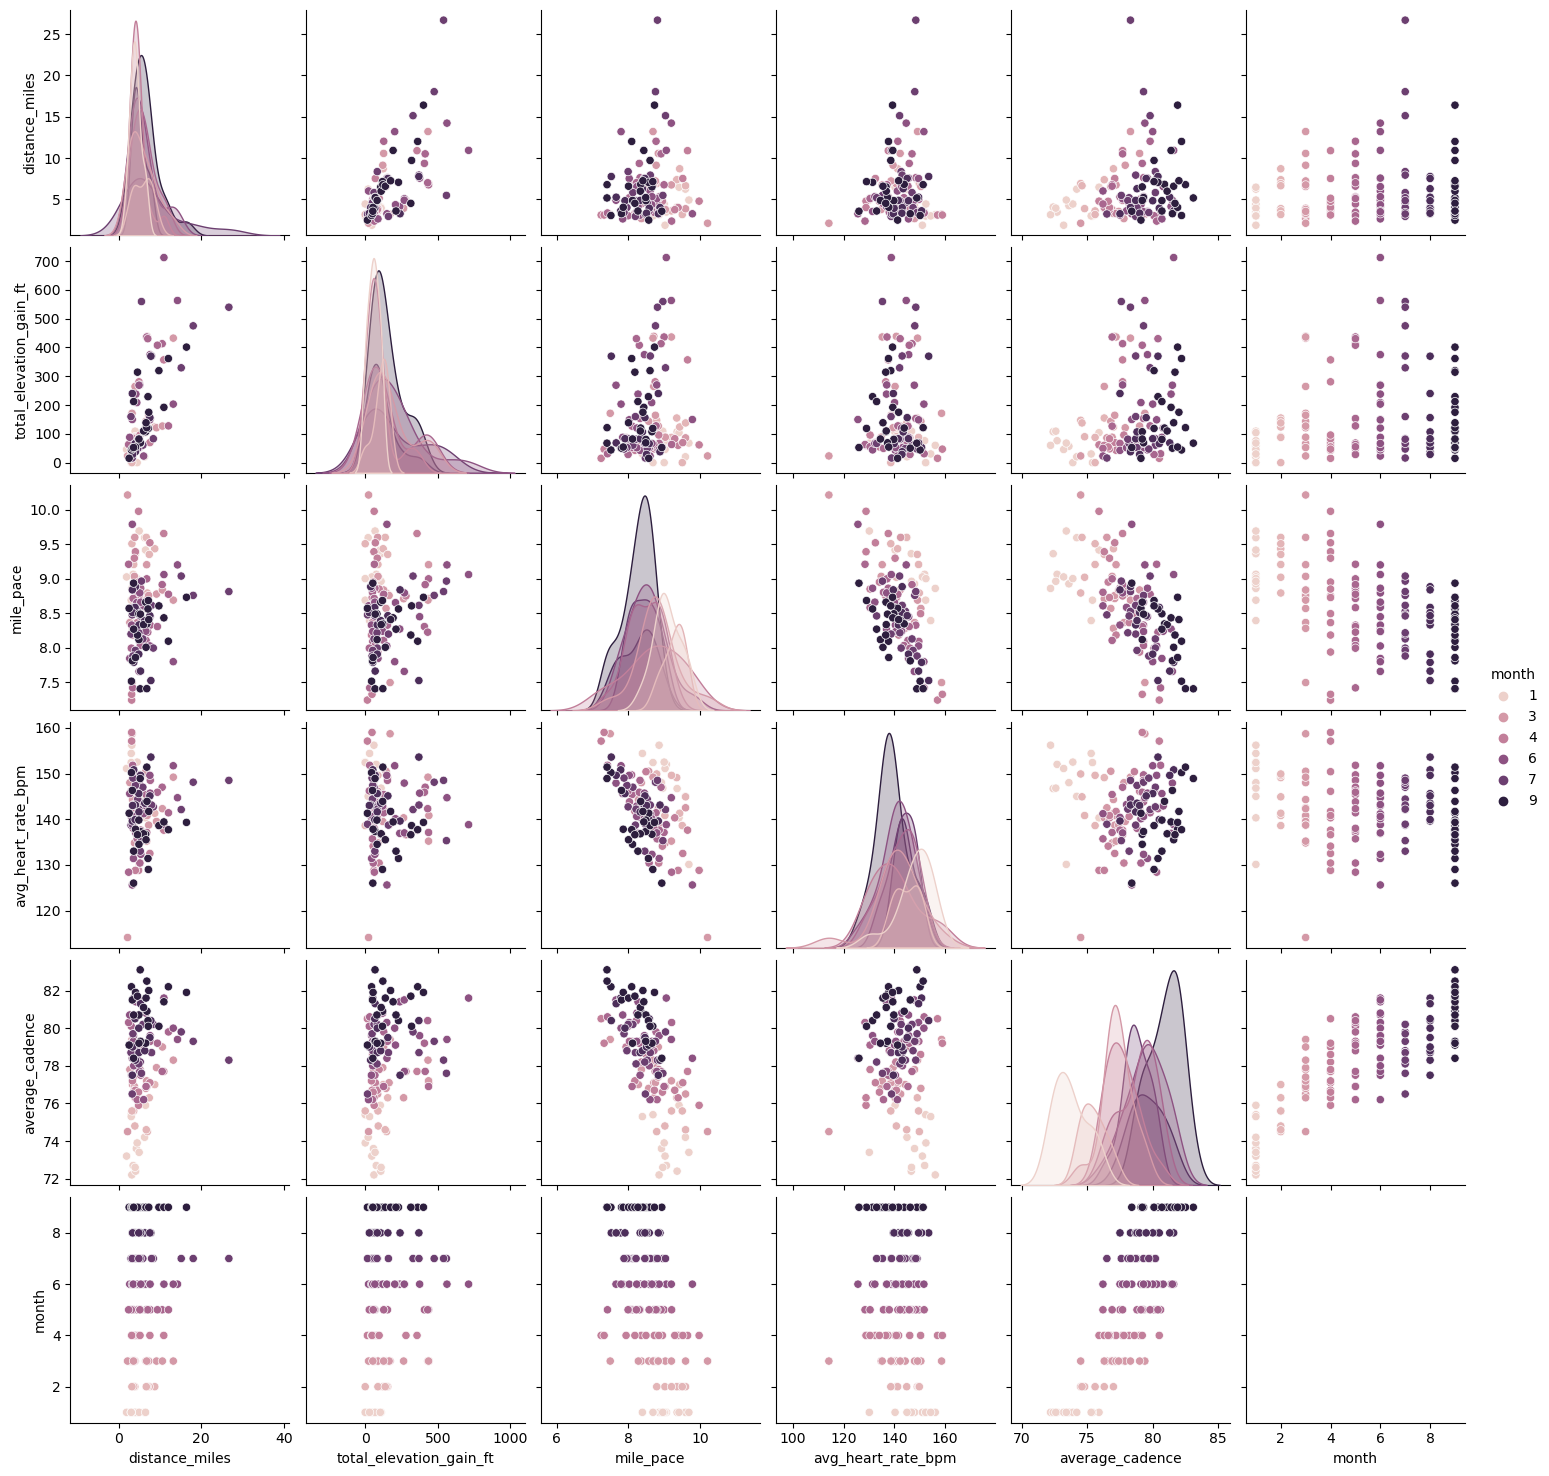

In [28]:
# create a pairplot to visualize the relationships between multiple numeric columns.
sns.pairplot(df[df.month  <= 9], vars=['distance_miles', 'total_elevation_gain_ft',
                       'mile_pace','avg_heart_rate_bpm','average_cadence', 'month'], hue = 'month')

### Observations from pairplot:
1. The majority of runs are under 5 miles and have < 100 ft of gain.
2. Cadence was lower in Jan and Februrary, has settled closer to 77 in more recent months
3. negative relationship between pace/heartrate, somewhat positive relationship between pace/distance
4. average heartrate varied accross all distances, trending lower in more recent months
5. longer runs tend to have more elevation gain; small positive correlation between distance and elevation gain

In [10]:
df.describe()

,distance_miles,moving_time_min,elapsed_time_min,total_elevation_gain_ft,comment_count,avg_speed_mph,max_speed_mph,average_cadence,avg_heart_rate_bpm,max_heart_rate_bpm,upload_id,pr_count,mile_pace,year,month,day,hour,minute,second,week,weekend
count,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,1.340000e+02,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000
mean,5.829357,50.229726,53.739055,145.226138,0.231343,7.017398,13.833905,78.254478,142.308209,159.574627,1.230447e+10,2.813433,8.589670,2023.977612,5.574627,15.313433,14.835821,31.104478,26.813433,22.470149,0.328358
std,3.506849,31.033510,33.785519,141.135014,0.681817,0.480868,4.098485,2.509669,7.557450,9.478410,6.432977e+08,3.633942,0.582244,0.148497,2.687696,9.016625,3.354257,18.691508,16.825137,11.803332,0.471378
min,1.885612,17.016667,17.200000,0.000000,0.000000,5.876441,6.502785,71.200000,114.100000,125.000000,1.099646e+10,0.000000,7.239769,2023.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,3.549753,31.108333,31.316667,52.493440,0.000000,6.716972,10.589674,76.900000,137.725000,154.000000,1.181078e+10,0.000000,8.226437,2024.000000,3.250000,7.000000,14.000000,14.000000,13.250000,13.250000,0.000000
50%,4.873257,40.216667,42.658333,84.481630,0.000000,6.972542,13.248277,78.700000,142.150000,159.000000,1.230673e+10,1.000000,8.605153,2024.000000,6.000000,15.500000,16.000000,34.000000,26.000000,22.500000,0.000000
75%,6.868153,60.533333,63.937500,169.537407,0.000000,7.292984,16.100376,80.100000,147.775000,167.000000,1.284492e+10,5.000000,8.931479,2024.000000,8.000000,23.000000,17.000000,48.750000,41.000000,32.000000,1.000000
max,26.673220,235.050000,237.000000,711.614196,4.000000,8.287863,26.087194,83.100000,160.100000,179.000000,1.337435e+10,18.000000,10.212014,2024.000000,12.000000,31.000000,21.000000,59.000000,59.000000,52.000000,1.000000


In [11]:
#runs by month
df.groupby('month_name').agg({'upload_id':'count','distance_miles':['mean','sum']})

upload_id distance_miles            
               count           mean         sum
month_name                                     
April             15       4.734110   71.011645
August            11       4.984243   54.826670
December           2       2.695383    5.390766
February           7       5.765568   40.358979
January           12       4.076945   48.923335
July              14       8.267909  115.750730
June              18       6.088732  109.597168
March             15       5.788618   86.829265
May               16       6.079447   97.271156
November           1       3.121022    3.121022
September         23       6.437093  148.053136

<Axes: xlabel='start_date_local', ylabel='cumulative_miles'>

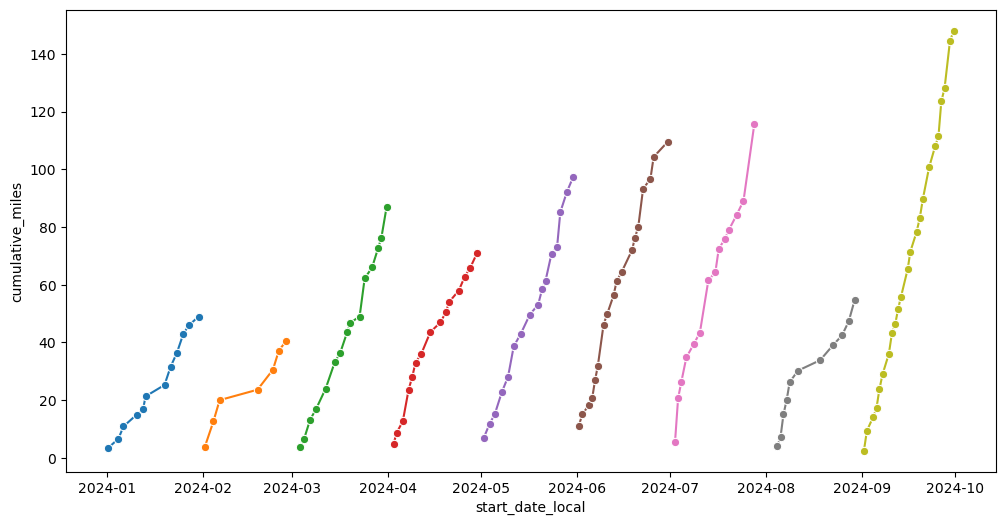

In [27]:
#calculate cumulative miles by month
df = df.sort_values('start_date')

df['cumulative_miles'] = df.groupby('month_name')['distance_miles'].cumsum()

#plot cumulative miles over time by month
plt.figure(figsize=(12, 6))
sns.lineplot(data = df[df.month <= 9], x='start_date_local', y='cumulative_miles', hue='month_name', marker='o', legend= None)

This plot illustrate how mileage is spread out through each month. In Februrary I was sick so the long pause after my 3rd run captures that period. I don't follow a plan, but a trend I can observe from this plot is several shorter runs, then one longer run every once in awhile. 

In [14]:
#summary statistics by day of week
df.groupby('day_of_week').agg({'upload_id':'count','distance_miles':['mean','sum']})

upload_id distance_miles            
                count           mean         sum
day_of_week                                     
Friday             15       4.263628   63.954424
Monday             18       4.786486   86.156755
Saturday           15       6.426774   96.401610
Sunday             24       8.126932  195.046369
Thursday           24       5.622123  134.930961
Tuesday            22       5.412670  119.078731
Wednesday          16       5.347814   85.565024

<Axes: xlabel='distance_miles', ylabel='day_of_week'>

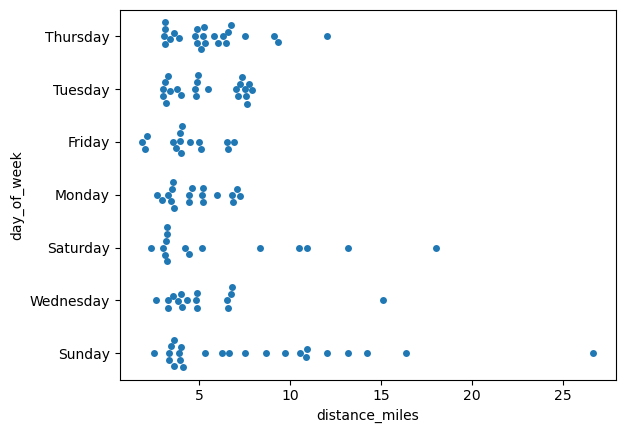

In [15]:
sns.swarmplot(data=df, x="distance_miles", y="day_of_week")

<Axes: xlabel='count', ylabel='month_name'>

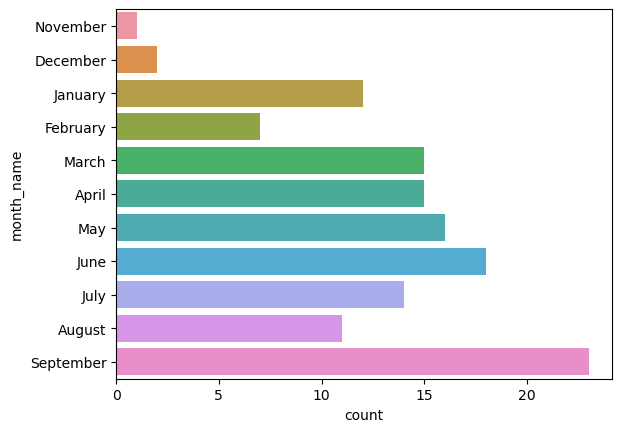

In [26]:
sns.countplot(df, y="month_name")

C:\Users\hw501f\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='distance_miles', ylabel='month_name'>

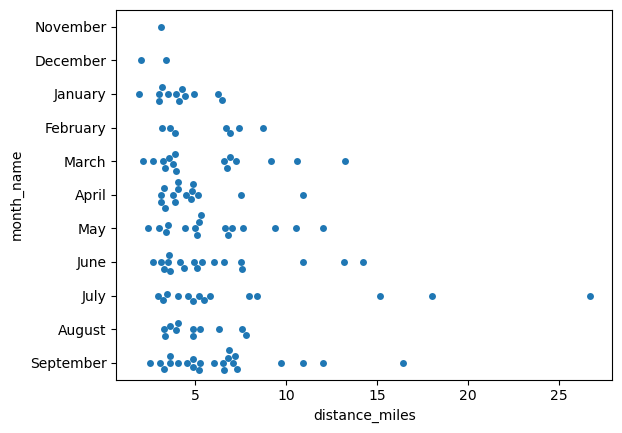

In [17]:
sns.swarmplot(data=df, x="distance_miles", y="month_name")

In [18]:
# Create 'time_of_day' column based on hour partitions
df['time_of_day'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'], right=False)

df.groupby('time_of_day').count()

,activity_name,distance_miles,moving_time_min,elapsed_time_min,total_elevation_gain_ft,sport_type,comment_count,avg_speed_mph,max_speed_mph,average_cadence,has_heartrate,avg_heart_rate_bpm,max_heart_rate_bpm,upload_id,gear_id,pr_count,start_date,start_date_local,mile_pace,day_of_week,year,month,month_name,day,hour,minute,second,time,date,week,weekend,cumulative_miles
time_of_day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
night,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
morning,20,20,20,20,20,20,20,20,20,20,20,20,20,20,19,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
afternoon,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95
evening,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18


<Axes: xlabel='hour', ylabel='Count'>

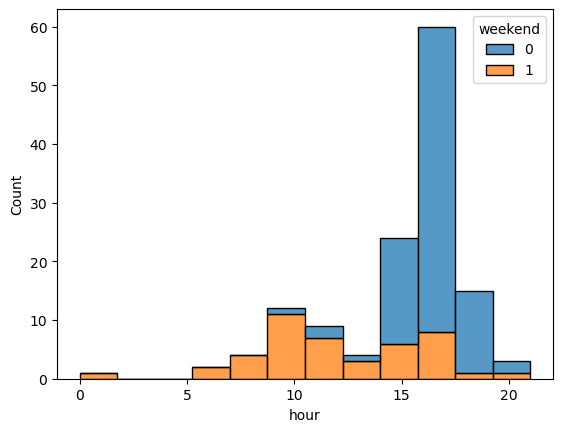

In [19]:
sns.histplot(data=df, x="hour", bins = 12, hue = 'weekend', multiple="stack")

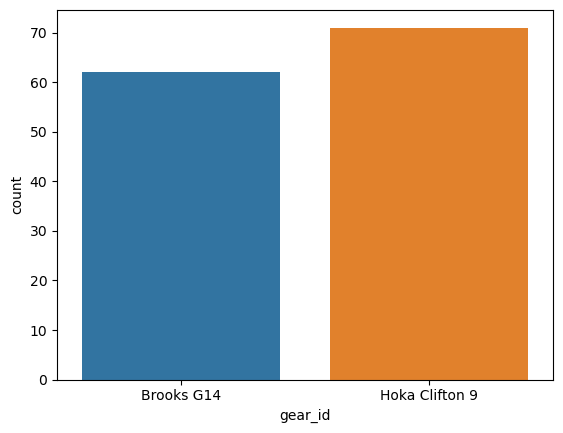

In [21]:
import seaborn as sns
sns.countplot(x="gear_id", data=df);

In [22]:
# df[df.isna().any(axis=1)]